# <font color="#8333ff">PROJET 3 : Préparez des données pour un organisme de santé publique

L’agence Santé publique France confie à votre entreprise la création d’un système de suggestion ou d’auto-complétion pour aider les usagers à remplir plus efficacement la base de données.
Nous pourrions imaginer que l'utilisateur saisisse le nom ou le code barre d'un produit et que l'algorithme se charge de compléter le reste des variables.
L'idée est donc de voir si un nombre limité de variables permet de déduire les autres.


Composantes **négatives** du nutriscore
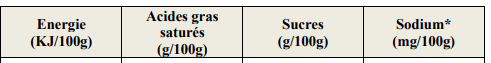

Composantes **positives** du nutriscore
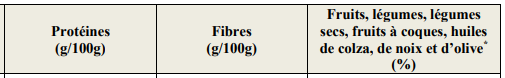


le Nutriscore varie de -15  à + 40

source:https://www.santepubliquefrance.fr/media/files/02-determinants-de-sante/nutrition-et-activite-physique/nutri-score/reglement-usage

In [1]:
import pandas as pd
import numpy as np
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt



from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer


from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn import preprocessing
from sklearn.decomposition import PCA

from scipy.stats import f_oneway
from scipy.stats import kstest
from scipy.stats import kruskal

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
pd.set_option('max_colwidth', 400)
customPalette = ['#048C3F','#93BF34','#F2B705','#F27405','#D93611']


# PARTIE 1 : Prise en main des données - Nettoyage

## Chargement des données

In [2]:
file_path = r'C:\Users\julie\Desktop\DATA\00_OPENCLASSROOMS\01_AI_ENGINEER\PROJET_03\P3_Sources\fr.openfoodfacts.org.products.csv'

In [3]:
#pré-chargement
data_preload = pd.read_csv(file_path,sep='\t',low_memory=False)

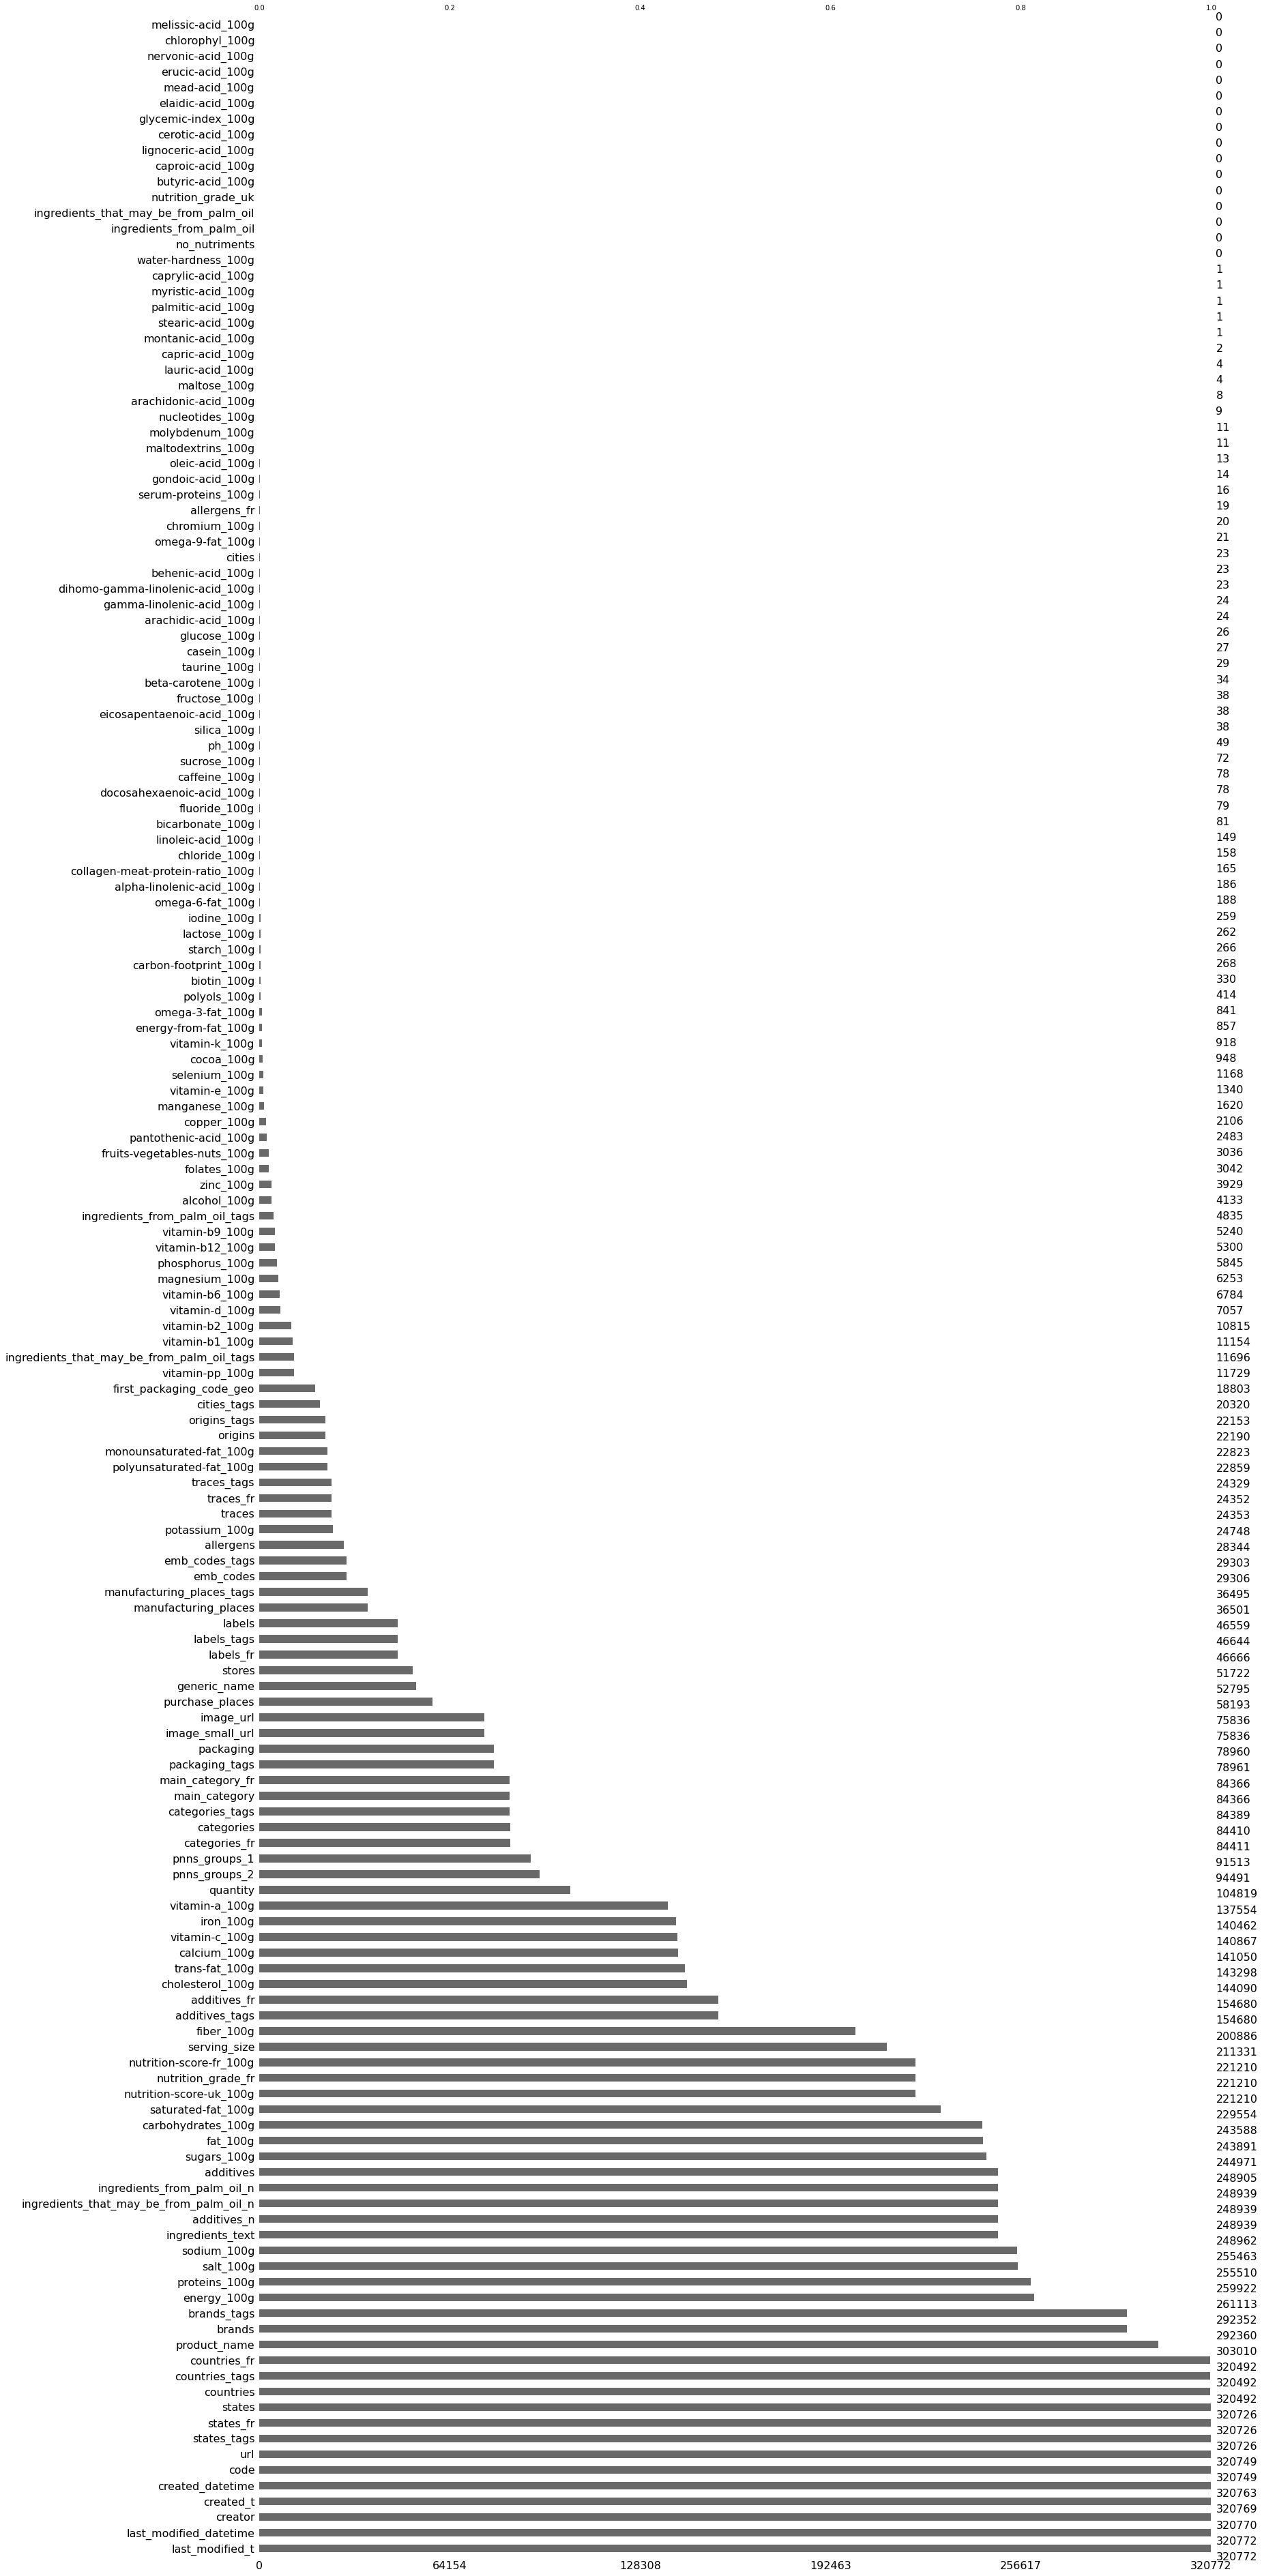

In [4]:
msno.bar(data_preload,sort="descending")
plt.show()

In [5]:
file_path = r'C:\Users\julie\Desktop\DATA\00_OPENCLASSROOMS\01_AI_ENGINEER\PROJET_03\P3_Sources\fr.openfoodfacts.org.products.csv'

In [6]:
def cleanP3 (file_path):
    
    #charger le fichier
    
    dataP3 = pd.read_csv(file_path,sep='\t',low_memory=False)
    
    
    
    #liste des variables retenues
    dataP3 = dataP3[['code', 'product_name','categories_fr',
                   'countries','nutrition_grade_fr',
                   'pnns_groups_1', 'pnns_groups_2',
                   'main_category_fr', 'energy_100g', 'saturated-fat_100g',
                    'sugars_100g', 'fiber_100g', 'proteins_100g',
                    'sodium_100g', 'fruits-vegetables-nuts_100g']]
    
    
    #suppression des doublons
    dataP3.drop_duplicates()
    
    if dataP3.code.duplicated().sum()>0:
        #on filtre les 22 lignes avec un code = nan
        dataP3=dataP3[~dataP3['code'].isna()]
        
      #On supprime les lignes où les varibables de caclul du NutriScore sont vides    
    ListRowNan =['energy_100g', 'saturated-fat_100g',
            'sugars_100g', 'fiber_100g', 'proteins_100g',
              'sodium_100g','fruits-vegetables-nuts_100g']

    dataP3=dataP3.dropna(subset= ListRowNan,how = 'all')
 
    
    
    return dataP3

In [7]:
dataP3 = cleanP3(file_path)


In [8]:
dataP3.shape

(262238, 15)

In [9]:
pd.DataFrame({
    "Modalités":dataP3.nunique(),
    "0" : (dataP3 == 0).mean(),
    "Null %":dataP3.isna().mean()}).sort_values(by="Null %",ascending=False)

,Modalités,0,Null %
fruits-vegetables-nuts_100g,333,0.003668,0.988423
categories_fr,16437,0.000000,0.756366
main_category_fr,2374,0.000000,0.756366
pnns_groups_1,14,0.000000,0.739466
pnns_groups_2,42,0.000000,0.738692
fiber_100g,1016,0.262483,0.233955
nutrition_grade_fr,5,0.000000,0.157178
saturated-fat_100g,2197,0.262113,0.124635
sugars_100g,4068,0.141387,0.065845
sodium_100g,5291,0.130153,0.025835


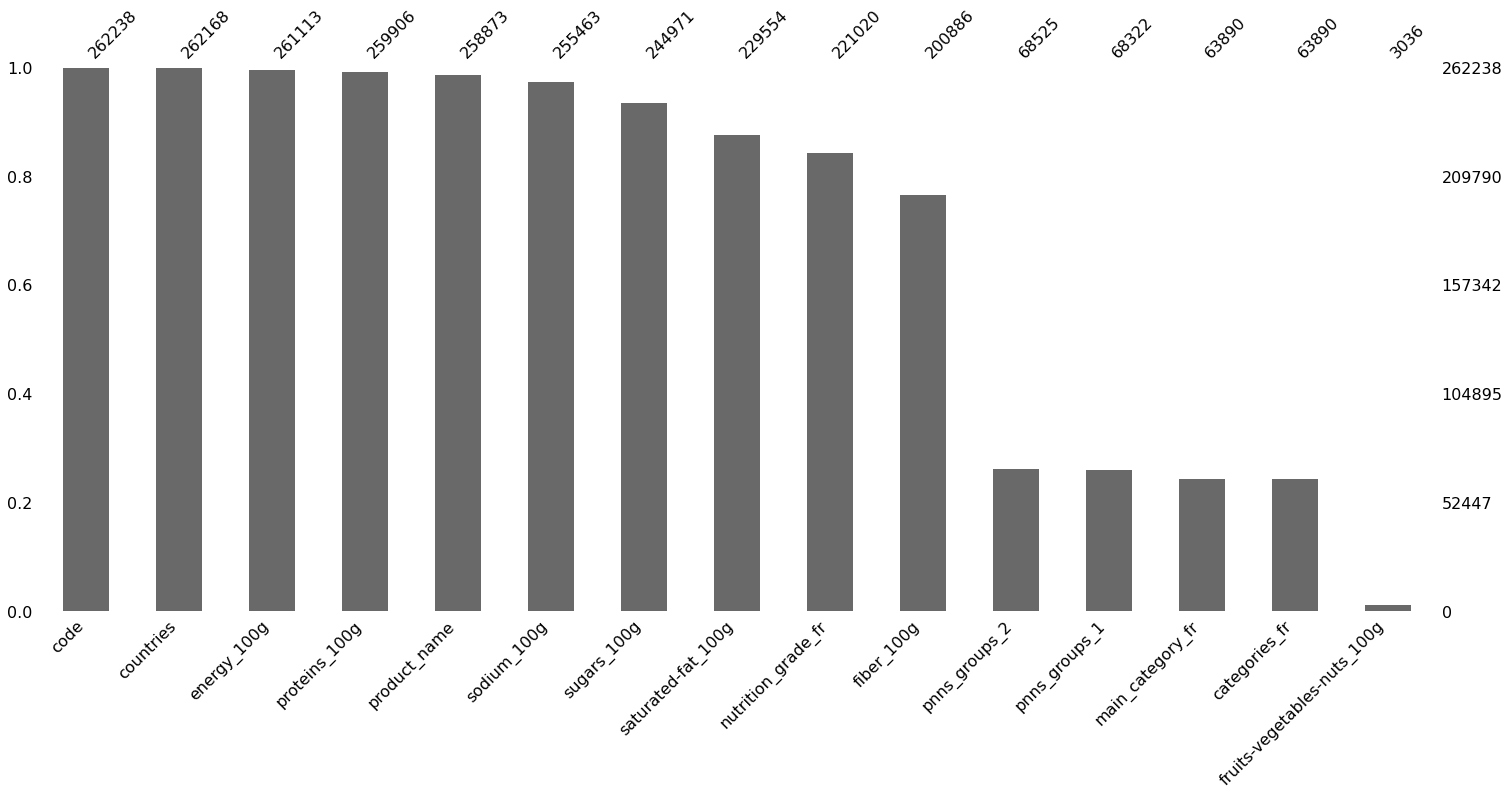

In [10]:
msno.bar(dataP3,sort="descending")
plt.show()

***
Nous sommes passé de plus de 320 000 individus à **262 238** et **15 variables**
***

In [11]:
dataP3.isna().mean().sort_values()

code                           0.000000
countries                      0.000267
energy_100g                    0.004290
proteins_100g                  0.008893
product_name                   0.012832
sodium_100g                    0.025835
sugars_100g                    0.065845
saturated-fat_100g             0.124635
nutrition_grade_fr             0.157178
fiber_100g                     0.233955
pnns_groups_2                  0.738692
pnns_groups_1                  0.739466
categories_fr                  0.756366
main_category_fr               0.756366
fruits-vegetables-nuts_100g    0.988423
dtype: float64

## Valeurs aberrantes

In [12]:
NumFeatures = ['energy_100g', 'saturated-fat_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g',
        'sodium_100g','fruits-vegetables-nuts_100g']

CategFeatures =['code','nutrition_grade_fr', 'product_name', 'categories_fr', 'countries'
       , 'pnns_groups_1', 'pnns_groups_2',
       'main_category_fr']


###  <font color="#1D438A">Valeurs catégorielles

In [13]:
dataP3.nunique()

code                           262238
product_name                   187046
categories_fr                   16437
countries                        1030
nutrition_grade_fr                  5
pnns_groups_1                      14
pnns_groups_2                      42
main_category_fr                 2374
energy_100g                      3997
saturated-fat_100g               2197
sugars_100g                      4068
fiber_100g                       1016
proteins_100g                    2494
sodium_100g                      5291
fruits-vegetables-nuts_100g       333
dtype: int64

In [14]:
print(dataP3['pnns_groups_1'].unique())

[nan 'unknown' 'Fruits and vegetables' 'Sugary snacks' 'Composite foods'
 'Fish Meat Eggs' 'Beverages' 'Fat and sauces' 'Cereals and potatoes'
 'Milk and dairy products' 'Salty snacks' 'fruits-and-vegetables'
 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']


Un certain nombre de modalité sont en double. On peut rationaliser

In [15]:
dataP3['pnns_groups_1'].replace(['cereals-and-potatoes','sugary-snacks','salty-snacks','fruits-and-vegetables'],
                                ['Cereals and potatoes','Sugary snacks','Salty snacks','Fruits and vegetables'],inplace=True)

In [16]:
dataP3['pnns_groups_2'].unique()

array([nan, 'unknown', 'Vegetables', 'Biscuits and cakes',
       'Pizza pies and quiche', 'Meat', 'Sweets', 'Sweetened beverages',
       'Dressings and sauces', 'One-dish meals', 'Soups', 'Cereals',
       'Fruits', 'Milk and yogurt', 'Fats', 'Non-sugared beverages',
       'Cheese', 'Chocolate products', 'Sandwich', 'Bread', 'Nuts',
       'Legumes', 'Breakfast cereals', 'Appetizers',
       'Artificially sweetened beverages', 'Fruit juices', 'Eggs',
       'Fish and seafood', 'Dried fruits', 'Ice cream', 'Processed meat',
       'Potatoes', 'vegetables', 'pastries', 'Dairy desserts',
       'Alcoholic beverages', 'Fruit nectars', 'fruits',
       'Salty and fatty products', 'Tripe dishes', 'cereals', 'legumes',
       'nuts'], dtype=object)

In [17]:
dataP3['pnns_groups_2'].replace(['Legumes','legumes','vegetables'],'Vegetables',inplace=True)
dataP3['pnns_groups_2'].replace(['cereals','nuts','fruits'],['Cereals','Nuts','Fruits'],inplace=True)

###  <font color="#1D438A">Valeurs numériques

In [18]:
dataP3.describe(include='all')

,code,product_name,categories_fr,countries,nutrition_grade_fr,pnns_groups_1,pnns_groups_2,main_category_fr,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
count,262238,258873,63890,262168,221020,68322,68525,63890,2.611130e+05,229554.000000,244971.000000,200886.000000,259906.000000,255463.000000,3036.000000
unique,262238,187046,16437,1030,5,10,36,2374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,0000000004530,Ice Cream,"Snacks sucrés,Biscuits et gâteaux,Biscuits",US,d,unknown,unknown,Boissons,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,410,708,169836,62763,12872,12872,2440,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.141915e+03,5.129932,16.003484,2.862111,7.076366,0.798815,31.458587
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.447154e+03,8.014238,22.327284,12.867578,8.409137,50.504428,31.967918
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,-17.860000,-6.700000,-800.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.770000e+02,0.000000,1.300000,0.000000,0.700000,0.025000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.100000e+03,1.790000,5.710000,1.500000,4.760000,0.229000,23.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.674000e+03,7.140000,24.000000,3.600000,10.000000,0.541000,51.000000


In [19]:
list_100g =['saturated-fat_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g',
        'sodium_100g']
#On remplace les valeurs négatives et  >100g pour 100g dans les colonnes ci-dessus
for col in list_100g :

    dataP3.loc[dataP3[col]>100, col] =np.nan
    dataP3.loc[dataP3[col]<0, col]=np.nan


In [20]:
#on remplace les valeurs >3500 KJ/100g (voir source fao)
dataP3.loc[dataP3['energy_100g']>4000,'energy_100g'] =np.nan

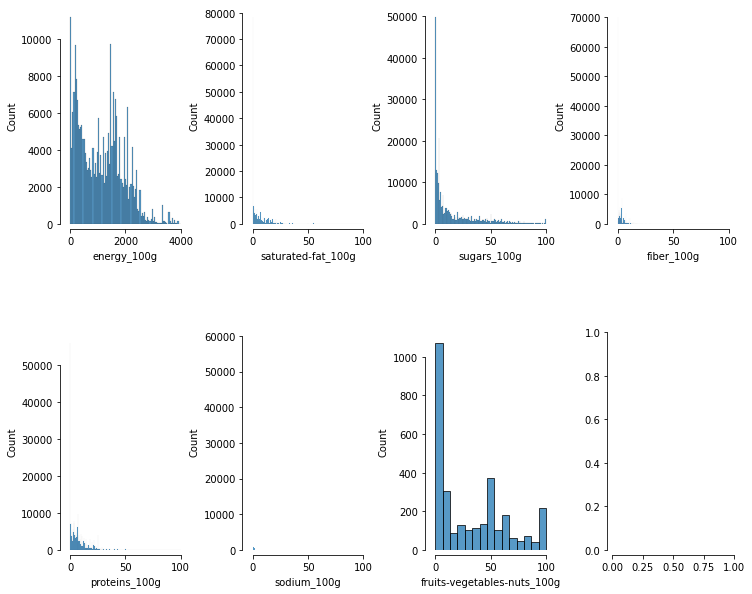

In [21]:
fig,axes = plt.subplots(2,4,figsize=(12,10),sharex=False,sharey=False)

plt.subplots_adjust(wspace=0.5, hspace=0.5)


for col,ax in zip(NumFeatures,axes.flatten()):

    sns.histplot(x=dataP3[col],ax=ax)


sns.despine(offset=5,trim=True)

<Figure size 432x288 with 0 Axes>

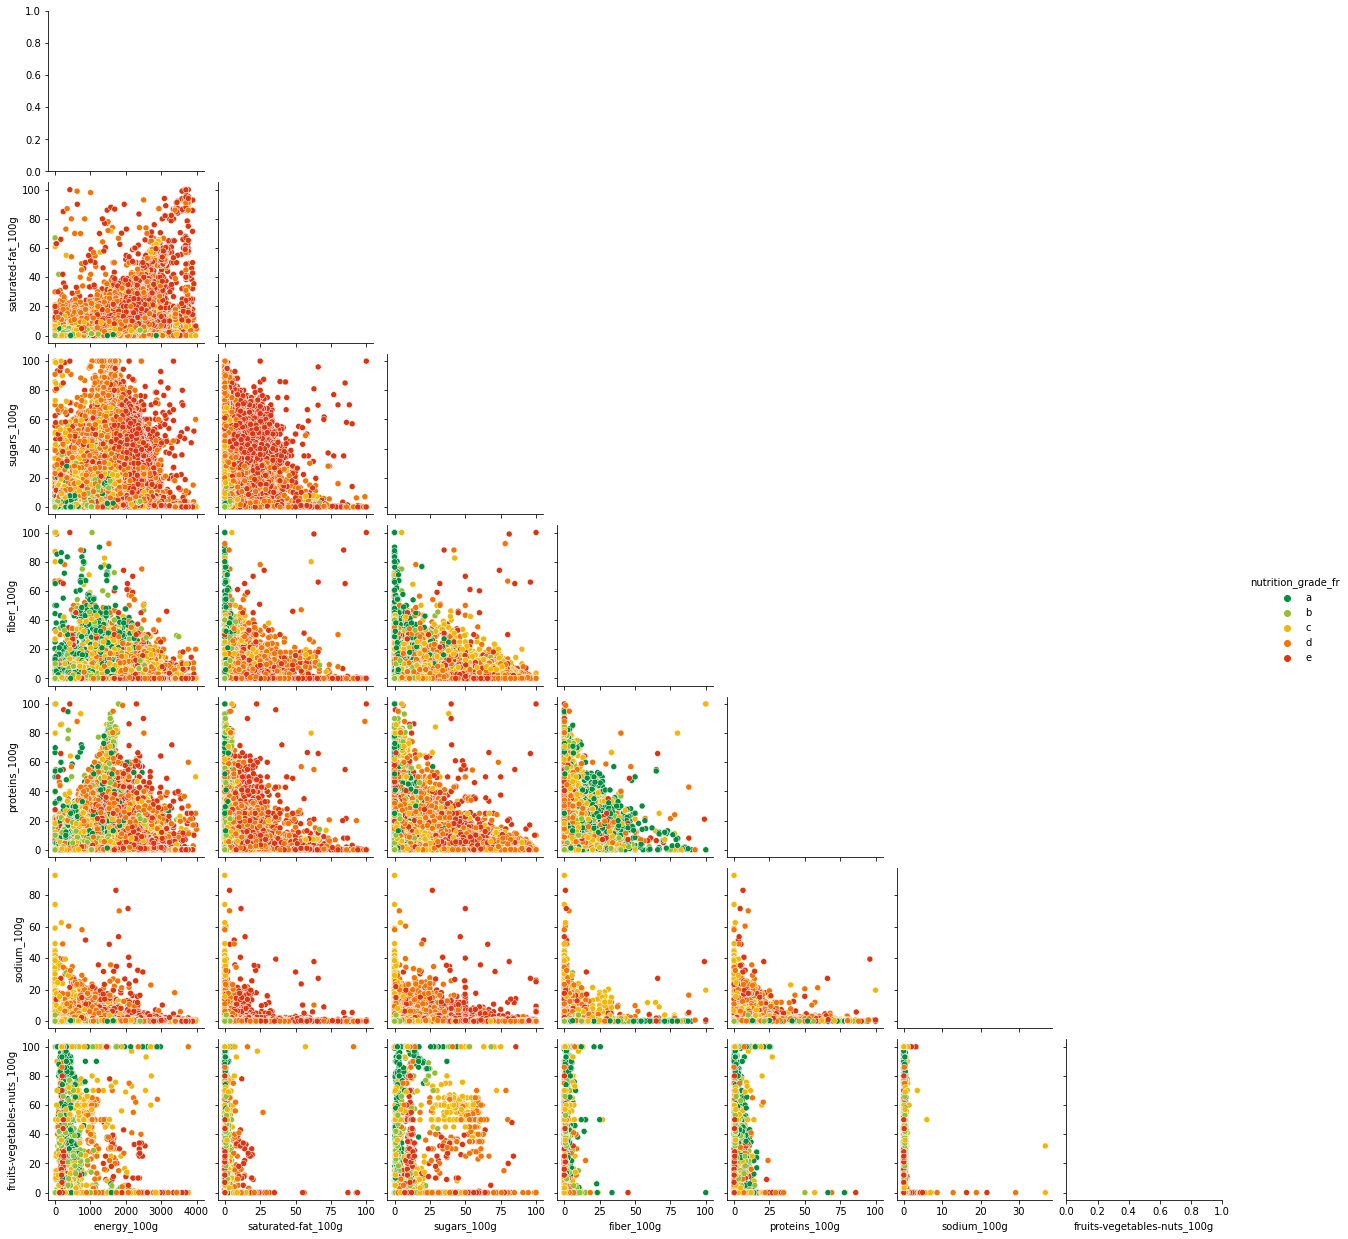

In [22]:
plt.figure()
hue_order = ['a', 'b', 'c','d','e']

sns.pairplot(dataP3 , hue = 'nutrition_grade_fr',corner = True,palette = customPalette ,diag_kind='none',hue_order=hue_order)
plt.show()


source https://www.fao.org/3/y5022e/y5022e04.htm  

### <font color="#1D438A">Traitement des outliers

Nous allons utiliser la méthode des écarts interquartiles pour traiter les outliers

In [23]:
d={}
lsup= []
linf=[]
for i in  NumFeatures:

    d["percentile25{0}".format(i)] = dataP3[i].quantile(0.25)
    d["percentile75{0}".format(i)] = dataP3[i].quantile(0.75)

    Iqr=d["percentile75{0}".format(i)]-d["percentile25{0}".format(i)]

    OutliersSup = dataP3[dataP3[i]> d["percentile75{0}".format(i)]+1.5*Iqr + dataP3[i].quantile(0.75) ]
    OutliersInf = dataP3[dataP3[i] < d["percentile25{0}".format(i)]-1.5*Iqr - dataP3[i].quantile(0.25) ]

    lsup.append(OutliersSup.shape[0])
    linf.append(OutliersInf.shape[0])

#on stock les résultats dans un DataFrame
pd.DataFrame({"Nb Outliers sup":lsup,"Nb Outliers inf":linf}).set_index(dataP3[NumFeatures].columns)

,Nb Outliers sup,Nb Outliers inf
energy_100g,0,0
saturated-fat_100g,4423,0
sugars_100g,3557,0
fiber_100g,5819,0
proteins_100g,2464,0
sodium_100g,10139,0
fruits-vegetables-nuts_100g,0,0


In [24]:
#nous remplaçons les outliers par Nan
for col in NumFeatures :
    Iqr = dataP3[col].quantile(0.75) - dataP3[col].quantile(0.25)

    dataP3.loc[dataP3[col]>(dataP3[col].quantile(0.75)+1.5*Iqr + dataP3[col].quantile(0.75)) , col] =np.nan


In [25]:
dataP3.describe()

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
count,260959.000000,225128.000000,241395.000000,195062.000000,257438.000000,245290.000000,3036.000000
mean,1123.689921,4.454039,14.860124,2.281329,6.711481,0.315549,31.458587
std,795.937819,5.889764,19.152240,2.783650,7.168517,0.362780,31.967918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,377.000000,0.000000,1.250000,0.000000,0.620000,0.020000,0.000000
50%,1100.000000,1.760000,5.400000,1.400000,4.650000,0.200000,23.000000
75%,1674.000000,7.000000,22.800000,3.500000,10.000000,0.493000,51.000000
max,4000.000000,24.900000,82.050000,12.600000,33.930000,1.855000,100.000000


# PARTIE 2 : Traitement des manquants



### Imputation "simple"

La variable "fruits-vegetables-nuts" est la moins renseigner.On peut supposer qu'une valeur Nan correspond à 0.

In [26]:
dataP3['fruits-vegetables-nuts_100g'].fillna(0,inplace=True)

In [27]:
dataP3.describe()

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
count,260959.000000,225128.000000,241395.000000,195062.000000,257438.000000,245290.000000,262238.000000
mean,1123.689921,4.454039,14.860124,2.281329,6.711481,0.315549,0.364205
std,795.937819,5.889764,19.152240,2.783650,7.168517,0.362780,4.811681
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,377.000000,0.000000,1.250000,0.000000,0.620000,0.020000,0.000000
50%,1100.000000,1.760000,5.400000,1.400000,4.650000,0.200000,0.000000
75%,1674.000000,7.000000,22.800000,3.500000,10.000000,0.493000,0.000000
max,4000.000000,24.900000,82.050000,12.600000,33.930000,1.855000,100.000000


### Iterative Imputer

Nous allons nous servir de l'iterative imputer pour attribuer "combler" les variables permettant de calculer le nutriscore

In [28]:
CategReplace = { "a":1 , "b":2 , "c":3 , "d":4 , "e":5 }

dataP3['nutrition_grade_fr'].replace(CategReplace,inplace=True)

In [29]:
dataP3_imputed = dataP3.copy()


In [30]:
imputer = IterativeImputer(random_state=0,min_value=0,max_value=4000)
dataP3_imputed[NumFeatures] = imputer.fit_transform(dataP3_imputed[NumFeatures])


In [31]:
dataP3_imputed.describe()

,nutrition_grade_fr,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
count,221020.000000,262238.000000,262238.000000,262238.000000,262238.000000,262238.000000,262238.000000,262238.000000
mean,3.196905,1123.690092,4.249960,15.180651,2.201564,6.739162,0.315925,0.364205
std,1.350063,794.743081,5.660923,18.887980,2.513345,7.130492,0.352830,4.811681
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,380.000000,0.000000,1.500000,0.000000,0.700000,0.027000,0.000000
50%,3.000000,1100.000000,1.700000,6.600000,1.500000,4.760000,0.220472,0.000000
75%,4.000000,1674.000000,6.600000,23.530000,3.300000,10.000000,0.479637,0.000000
max,5.000000,4000.000000,24.900000,82.050000,12.600000,33.930000,1.855000,100.000000


### KNN

Maintenant que nous avons toutes les variables de calcul du Nutriscore nous utilisons le KNN pour attribuer un nutriscore aux individus qui n'en n'ont pas.

In [32]:
dataP3_KNN= dataP3_imputed.copy()

In [33]:
dataP3_KNN.isna().sum()

code                                0
product_name                     3365
categories_fr                  198348
countries                          70
nutrition_grade_fr              41218
pnns_groups_1                  193916
pnns_groups_2                  193713
main_category_fr               198348
energy_100g                         0
saturated-fat_100g                  0
sugars_100g                         0
fiber_100g                          0
proteins_100g                       0
sodium_100g                         0
fruits-vegetables-nuts_100g         0
dtype: int64

In [34]:
imputer_KNN = KNNImputer(n_neighbors=1)

In [35]:
dataP3_KNN= dataP3_KNN[['nutrition_grade_fr','energy_100g', 'saturated-fat_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g',
        'sodium_100g','fruits-vegetables-nuts_100g']]

In [36]:
imputer_KNN.fit(dataP3_KNN)


KNNImputer(n_neighbors=1)

In [37]:
dataP3_KNN=imputer_KNN.transform(dataP3_KNN)


In [38]:
dataP3_KNN = pd.DataFrame(dataP3_KNN,columns=['nutrition_grade_fr','energy_100g', 'saturated-fat_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g',
        'sodium_100g','fruits-vegetables-nuts_100g'])

https://towardsdatascience.com/iterative-imputation-with-scikit-learn-8f3eb22b1a38

In [39]:
dataP3_clean = pd.concat([dataP3_imputed[['code','product_name', 'categories_fr', 'countries'
       , 'pnns_groups_1', 'pnns_groups_2',
       'main_category_fr']].reset_index(),dataP3_KNN],axis=1)

In [40]:
dataP3_clean.isna().sum()

index                               0
code                                0
product_name                     3365
categories_fr                  198348
countries                          70
pnns_groups_1                  193916
pnns_groups_2                  193713
main_category_fr               198348
nutrition_grade_fr                  0
energy_100g                         0
saturated-fat_100g                  0
sugars_100g                         0
fiber_100g                          0
proteins_100g                       0
sodium_100g                         0
fruits-vegetables-nuts_100g         0
dtype: int64

# PARTIE 3 : Analyses

## Analyses univariées

In [41]:
CategReplaceBack = { 1.0:"A" , 2.0:"B" , 3.0:"C" , 4.0:"D" , 5.0:"E"}
dataP3_clean['nutrition_grade_fr'].replace(CategReplaceBack,inplace=True)

In [42]:
dataP3_clean.shape

(262238, 16)

###  <font color="#1D438A">Nombre de produits par NutriScore 

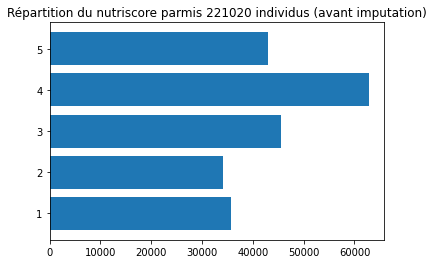

In [43]:

plt.figure()
pie_nutrition = dataP3['nutrition_grade_fr'].value_counts()

plt.barh(width= pie_nutrition, y = pie_nutrition.index)


plt.title("Répartition du nutriscore parmis "+str(dataP3['nutrition_grade_fr'].value_counts().sum())+" individus (avant imputation)")
plt.show()

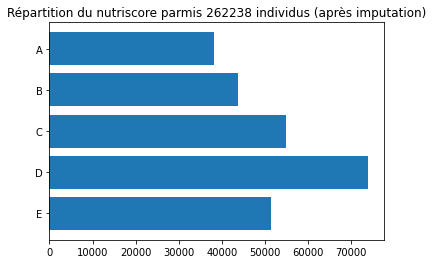

In [44]:
plt.figure()
pie_nutrition_KNN =  pd.DataFrame(dataP3_clean['nutrition_grade_fr'].value_counts()).sort_index(ascending=False)



plt.barh(width=pie_nutrition_KNN['nutrition_grade_fr'], y = pie_nutrition_KNN.index)

plt.title("Répartition du nutriscore parmis "+str(dataP3_clean['nutrition_grade_fr'].value_counts().sum())+" individus (après imputation)")

plt.show()

###  <font color="#1D438A">Répartion des produits par NustriSore et par pays

In [45]:
df_Coutries_Rank = dataP3_clean.groupby(['countries','nutrition_grade_fr'])[['nutrition_grade_fr']].agg('count').unstack(level=1)

df_Coutries_Rank =df_Coutries_Rank.sort_values(('nutrition_grade_fr', "A"),ascending=False)

df_Coutries_Rank['Total_product %'] = df_Coutries_Rank.sum(axis=1)
df_Coutries_Rank['Total_product'] = df_Coutries_Rank.sum(axis=1)
for col in df_Coutries_Rank.columns :    
    
    df_Coutries_Rank[col] = (df_Coutries_Rank[col] / df_Coutries_Rank['Total_product %'])*100
df_Coutries_Rank = df_Coutries_Rank.nlargest(5,columns ='Total_product')
df_Coutries_Rank

nutrition_grade_fr                                   \
nutrition_grade_fr                  A          B          C          D   
countries                                                                
US                          13.567795  17.416213  20.548058  28.518100   
France                      16.612600  15.128463  21.671641  27.870953   
Suisse                      13.805256  16.695197  23.220220  26.875441   
Deutschland                 16.266174  14.024954  19.801294  26.963956   
España                      25.118656  16.940489  23.767798  21.832786   

                              Total_product % Total_product  
nutrition_grade_fr          E                                
countries                                                    
US                  19.949834           100.0      339672.0  
France              18.716343           100.0      123304.0  
Suisse              19.403887           100.0       19862.0  
Deutschland         22.943623           100.0        8656.0  
España              12.340270           100.0        5478.0

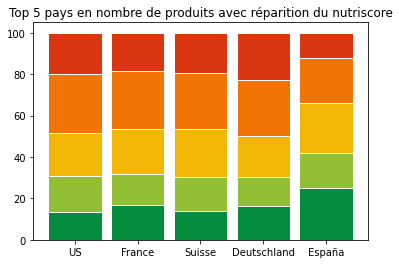

In [46]:
'#048C3F','#93BF34','#F2B705','#F27405','#D93611'

plt.bar(x= df_Coutries_Rank.index ,
        width =.85 ,
        height= df_Coutries_Rank[('nutrition_grade_fr', 'A')],
        color='#048C3F',
        edgecolor='white')
plt.bar(x= df_Coutries_Rank.index,
        width =.85,
        height= df_Coutries_Rank[('nutrition_grade_fr', 'B')],
        color='#93BF34',
        edgecolor='white',
       bottom =df_Coutries_Rank[('nutrition_grade_fr', 'A')] )
plt.bar(x= df_Coutries_Rank.index,
        width =.85,
        height= df_Coutries_Rank[('nutrition_grade_fr', 'C')],
        color='#F2B705',
        edgecolor='white',
        bottom = [i+j for i,j in zip(df_Coutries_Rank[('nutrition_grade_fr', 'A')],df_Coutries_Rank[('nutrition_grade_fr', 'B')])] )
plt.bar(x= df_Coutries_Rank.index,
        width =.85,
        height= df_Coutries_Rank[('nutrition_grade_fr', 'D')],
        color='#F27405',
        edgecolor='white',
       bottom =[i+j+k for i,j,k in zip(df_Coutries_Rank[('nutrition_grade_fr', 'A')],df_Coutries_Rank[('nutrition_grade_fr', 'B')],df_Coutries_Rank[('nutrition_grade_fr', 'C')] )])
plt.bar(x= df_Coutries_Rank.index,
        width =.85,
        height= df_Coutries_Rank[('nutrition_grade_fr', 'E')],
        color='#D93611',
        edgecolor='white',
   bottom =[i+j+k+l for i,j,k,l in zip(df_Coutries_Rank[('nutrition_grade_fr', 'A')],df_Coutries_Rank[('nutrition_grade_fr', 'B')],df_Coutries_Rank[('nutrition_grade_fr', 'C')] ,df_Coutries_Rank[('nutrition_grade_fr', 'D')])] )



plt.title('Top 5 pays en nombre de produits avec réparition du nutriscore')
plt.show()

In [47]:
df_Coutries_Rank.head()[('nutrition_grade_fr', 'A')]

countries
US             13.567795
France         16.612600
Suisse         13.805256
Deutschland    16.266174
España         25.118656
Name: (nutrition_grade_fr, A), dtype: float64

In [48]:
dataP3_clean['pnns_groups_1'].value_counts().sort_values(ascending=False)

unknown                    12872
Sugary snacks              10706
Milk and dairy products     7496
Cereals and potatoes        7465
Beverages                   6520
Composite foods             6036
Fish Meat Eggs              5878
Fruits and vegetables       4759
Fat and sauces              4116
Salty snacks                2474
Name: pnns_groups_1, dtype: int64

###  <font color="#1D438A">Repartition des produits dans les catégories 'pnns_groups_1','pnns_groups_2' et 'main_category_fr'

In [49]:

Top_10 = dataP3.loc[(dataP3['pnns_groups_2']!="other"),'pnns_groups_2'].value_counts().nlargest(10)
Top_10['Autres'] =sum(dataP3.loc[(dataP3['pnns_groups_2']!="other"),'pnns_groups_2'].value_counts()[10:])



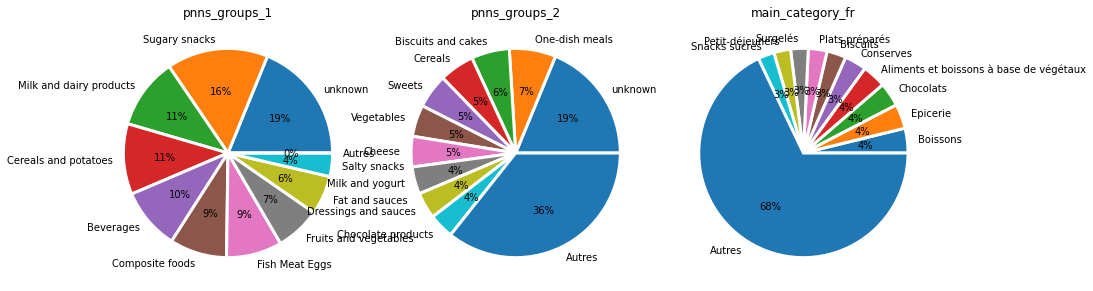

In [50]:
list_pnns = ['pnns_groups_1','pnns_groups_2','main_category_fr']


fig,axes = plt.subplots(1,3,figsize=(15,15))

for col,ax in zip(list_pnns,axes.flatten()):

    Top_10 = dataP3.loc[(dataP3[col]!="other"),col].value_counts().nlargest(10)
    Top_10['Autres'] =sum(dataP3.loc[(dataP3[col]!="other"),col].value_counts()[10:])

    ax.pie(x=Top_10,wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                                    labels=Top_10.index,
                                    autopct='%1.0f%%')

    ax.set_title(col)

plt.subplots_adjust( wspace=.1, hspace=13)
# left=.1, bottom=0.1, right=1.1, top=0.7,
plt.show()

###  <font color="#1D438A">Répartition des Nutriscore dans les catégories 'pnns1'

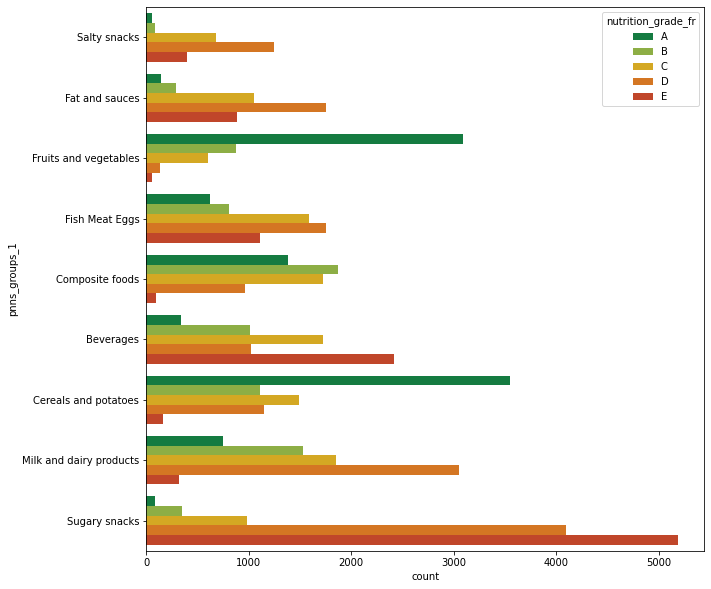

In [51]:
filtre = ~dataP3_clean['pnns_groups_1'].isin(["other","unknown"])

barplot_data = dataP3_clean.loc[filtre,['nutrition_grade_fr','pnns_groups_1']].groupby('pnns_groups_1')['nutrition_grade_fr'].count().sort_values()

plt.figure(figsize=(10,10))

hue_order = ['A','B','C','D','E']

sns.countplot(y='pnns_groups_1', hue='nutrition_grade_fr',hue_order=hue_order,data=dataP3_clean ,order= barplot_data.index,palette=customPalette)
plt.show()


le graphique ci-dessus nous informe que le nutriscore E est fortement représentée par les snacks sucrés ainsi que le boissons.
A l'opposé, la catégorie A est majoritairement composée de céréales, fruit et légumes

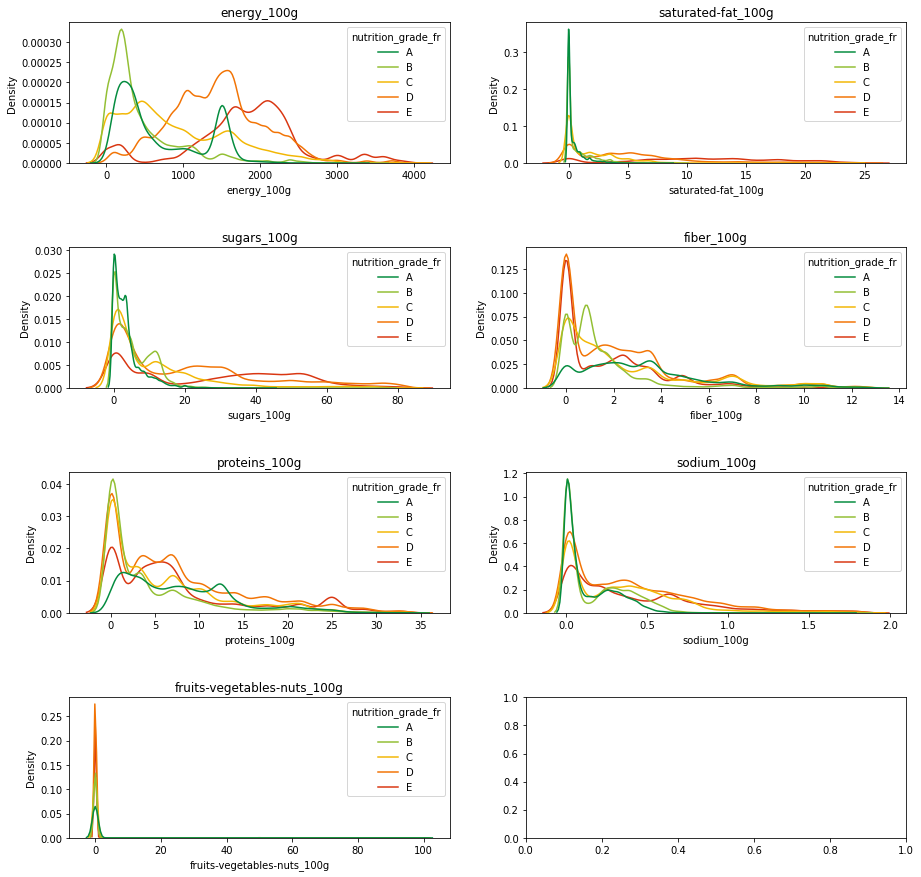

In [52]:
fig,axes = plt.subplots(4,2,figsize=(15,15))
plt.subplots_adjust(hspace=.6)

list_100g=['energy_100g', 'saturated-fat_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g',
        'sodium_100g','fruits-vegetables-nuts_100g']
for col,ax in zip(list_100g,axes.flatten()):



    sns.kdeplot(data= dataP3_clean,x=dataP3_KNN[col],hue='nutrition_grade_fr',hue_order=hue_order,palette=customPalette,ax=ax )

    ax.set_title(col)



plt.show()

Les variables ont une distribution assez similaires quelque soit le NutriScore. Seul la variable "energy" montre une distribution quasi normale "visuellement" pour les catégories D et E

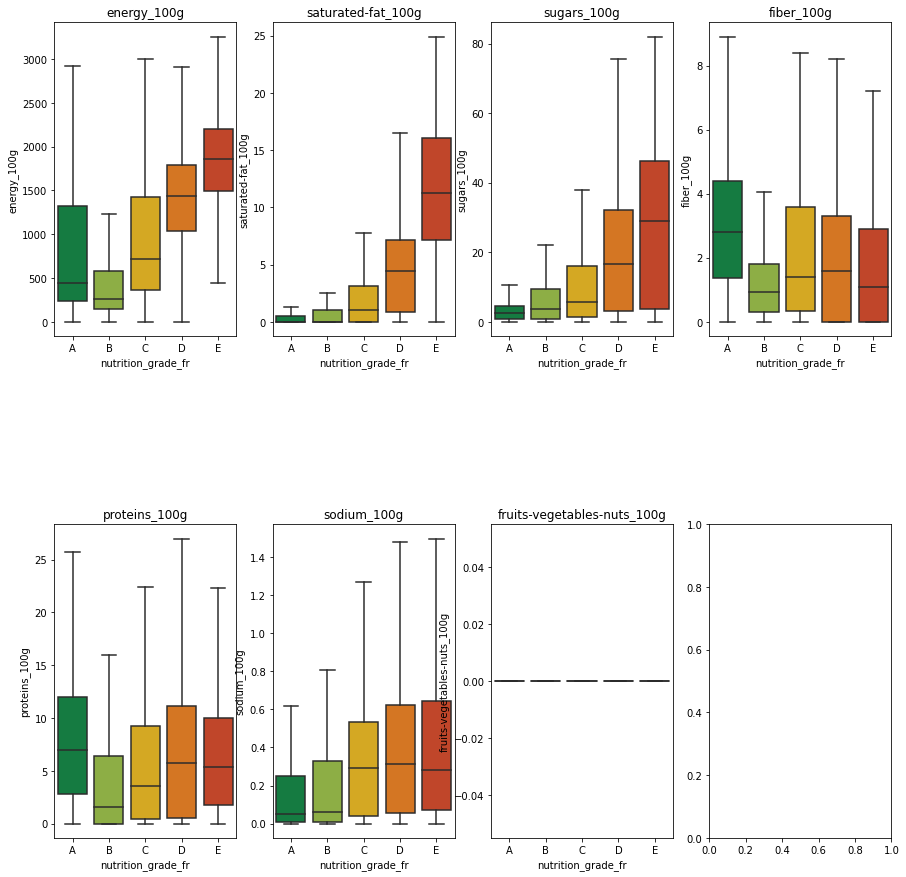

In [53]:
fig,axes = plt.subplots(2,4,figsize=(15,15))

plt.subplots_adjust(hspace=.6)

list_100g=['energy_100g', 'saturated-fat_100g',
        'sugars_100g', 'fiber_100g', 'proteins_100g',
        'sodium_100g','fruits-vegetables-nuts_100g']

for col,ax in zip(list_100g,axes.flatten()):



    sns.boxplot(x=dataP3_clean['nutrition_grade_fr'].sort_values(),y=dataP3_clean[col],showfliers = False,palette= customPalette,ax=ax )


    ax.set_title(col)



plt.show()

Graisses et sucres semblent influencer fortement les notes D et E et leur faible présence orientera la note vers A ou B.
Les produits de la catégorie B ont des valeurs souvent en retrait ( énergie, fibres et protéïnes)

## ANOVA

Y a-t-il une différence significative entre les différents nutriscores A,B,C,D,E?

   Hypothèse **H0** -> la différence entre les moyennes des différents groupes n'est pas significative.

Nous commençons par effectuer un **test de normalité** sur nos différentes variables indépendantes.<br>
L'hypothèse **H0** étant que la distribution des différentes variables quantitatives ne suit pas une loi normale

In [54]:
list_norm_test = ['energy_100g','saturated-fat_100g','sugars_100g','fiber_100g','proteins_100g','sodium_100g','fruits-vegetables-nuts_100g']
list_df = []

for i in list_norm_test :

    result=kstest(dataP3_clean[i],'norm')[1]
    list_df.append(result)

pd.DataFrame({'Var':list_norm_test,'p_value pour la normalité':list_df}).set_index('Var')

,p_value pour la normalité
Var,
energy_100g,0.0
saturated-fat_100g,0.0
sugars_100g,0.0
fiber_100g,0.0
proteins_100g,0.0
sodium_100g,0.0
fruits-vegetables-nuts_100g,0.0


Avec une p_value nulle pour toutes les variables tester, nous pouvons conclure que celle-ci **ne suivent pas une loi normale**

Les variables ne suivant pas une loi normale, nous allons privilégier le test de **Kruskal-Wallis**, test non paramétrique.

In [55]:
groupes= ['A','B','C','D','E']
result_groupes =[]
rows = []
df_KW = pd.DataFrame()

for var in list_norm_test:

    for gpe in groupes:

        result_gpe = pd.Series(dataP3_clean.loc[dataP3_clean['nutrition_grade_fr']== gpe ,var],name="Groupe{0}".format(gpe))
        result_groupes.append(result_gpe)

    result_var = pd.Series(kruskal(*result_groupes) , name= var )
    df_KW[var] = result_var
df_KW.rename(index= {0:"Stat" , 1: "p_value"})

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
Stat,98715.063814,407738.588941,559122.719893,674328.406122,750192.702936,882497.987027,1.156586e+06
p_value,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00


***
La p_value est inférieure à 0.05. L'hypothèse H0 est vérifiée et il y a donc bien une différence significative entre les différents groupes.
***

## ACP

In [56]:
NutriscoreEncode=pd.get_dummies(data= dataP3_clean[['nutrition_grade_fr','pnns_groups_2']],columns=['nutrition_grade_fr','pnns_groups_2'])
dataP3_PCA = pd.concat([dataP3_clean[['energy_100g', 'saturated-fat_100g',
                                'sugars_100g', 'fiber_100g', 'proteins_100g', 'sodium_100g']],
                    NutriscoreEncode],axis=1)

dataP3_PCA.sample(5)

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition_grade_fr_A,nutrition_grade_fr_B,nutrition_grade_fr_C,nutrition_grade_fr_D,nutrition_grade_fr_E,pnns_groups_2_Alcoholic beverages,pnns_groups_2_Appetizers,pnns_groups_2_Artificially sweetened beverages,pnns_groups_2_Biscuits and cakes,pnns_groups_2_Bread,pnns_groups_2_Breakfast cereals,pnns_groups_2_Cereals,pnns_groups_2_Cheese,pnns_groups_2_Chocolate products,pnns_groups_2_Dairy desserts,pnns_groups_2_Dressings and sauces,pnns_groups_2_Dried fruits,pnns_groups_2_Eggs,pnns_groups_2_Fats,pnns_groups_2_Fish and seafood,pnns_groups_2_Fruit juices,pnns_groups_2_Fruit nectars,pnns_groups_2_Fruits,pnns_groups_2_Ice cream,pnns_groups_2_Meat,pnns_groups_2_Milk and yogurt,pnns_groups_2_Non-sugared beverages,pnns_groups_2_Nuts,pnns_groups_2_One-dish meals,pnns_groups_2_Pizza pies and quiche,pnns_groups_2_Potatoes,pnns_groups_2_Processed meat,pnns_groups_2_Salty and fatty products,pnns_groups_2_Sandwich,pnns_groups_2_Soups,pnns_groups_2_Sweetened beverages,pnns_groups_2_Sweets,pnns_groups_2_Tripe dishes,pnns_groups_2_Vegetables,pnns_groups_2_pastries,pnns_groups_2_unknown
41119,176.0,0.000000,11.83,0.934076,0.00,0.000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
105615,2197.0,8.662708,42.50,3.777009,7.50,0.000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82853,2092.0,5.360000,0.00,7.100000,7.14,0.268,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
103159,100.0,0.000000,2.35,2.400000,1.18,0.047,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
94567,138.0,0.000000,3.33,3.300000,0.00,0.000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
dataP3_PCA.shape

(262238, 47)

In [58]:
X_PCA = dataP3_PCA.values
X_PCA = preprocessing.StandardScaler().fit_transform(X_PCA)

Nous allons vérifier que les variables ont bien été "centrées-réduites"

In [59]:
#Nous limitons notre étude à 3 complosantes principales pour faciliter l'interprétation
pca = PCA(n_components=3)

X = pca.fit_transform(X_PCA)

In [60]:
# Analyse des valeurs propres
Summary = pd.DataFrame(
    {
        "Dimension" : ['F' + str(i+1)  for i in range(0, len(pca.explained_variance_))],
        "Valeur propre" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    },
    columns = ["Dimension", "Valeur propre", "% variance expliquée", "% cum. var. expliquée"]
)
Summary

,Dimension,Valeur propre,% variance expliquée,% cum. var. expliquée
0,F1,2.991394,6.0,6.0
1,F2,1.919623,4.0,10.0
2,F3,1.629200,3.0,14.0


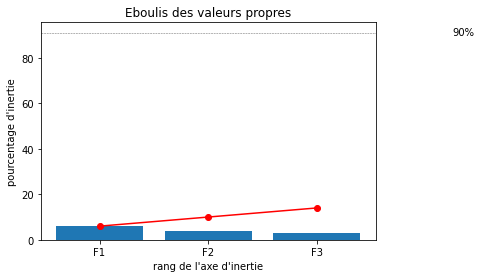

In [61]:
plt.figure()
plt.bar(Summary['Dimension'], Summary['% variance expliquée'])
plt.plot(Summary['Dimension'], Summary['% cum. var. expliquée'],c="red",marker='o')
plt.axhline(y = 91, linewidth = .5, color = "dimgray", linestyle = "--")
plt.text(3.25, 90, "90%")
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

In [62]:
pcs = pd.DataFrame(pca.components_,columns = dataP3_PCA.columns)
pcs

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition_grade_fr_A,nutrition_grade_fr_B,nutrition_grade_fr_C,nutrition_grade_fr_D,nutrition_grade_fr_E,pnns_groups_2_Alcoholic beverages,pnns_groups_2_Appetizers,pnns_groups_2_Artificially sweetened beverages,pnns_groups_2_Biscuits and cakes,pnns_groups_2_Bread,pnns_groups_2_Breakfast cereals,pnns_groups_2_Cereals,pnns_groups_2_Cheese,pnns_groups_2_Chocolate products,pnns_groups_2_Dairy desserts,pnns_groups_2_Dressings and sauces,pnns_groups_2_Dried fruits,pnns_groups_2_Eggs,pnns_groups_2_Fats,pnns_groups_2_Fish and seafood,pnns_groups_2_Fruit juices,pnns_groups_2_Fruit nectars,pnns_groups_2_Fruits,pnns_groups_2_Ice cream,pnns_groups_2_Meat,pnns_groups_2_Milk and yogurt,pnns_groups_2_Non-sugared beverages,pnns_groups_2_Nuts,pnns_groups_2_One-dish meals,pnns_groups_2_Pizza pies and quiche,pnns_groups_2_Potatoes,pnns_groups_2_Processed meat,pnns_groups_2_Salty and fatty products,pnns_groups_2_Sandwich,pnns_groups_2_Soups,pnns_groups_2_Sweetened beverages,pnns_groups_2_Sweets,pnns_groups_2_Tripe dishes,pnns_groups_2_Vegetables,pnns_groups_2_pastries,pnns_groups_2_unknown
0,0.494861,0.469715,0.260136,0.139845,0.206894,0.142677,-0.195072,-0.280398,-0.130841,0.177784,0.369140,-0.012713,0.039435,-0.027624,0.106272,-0.013632,0.011375,-0.031548,0.070529,0.137394,-0.021042,-0.018420,0.000083,-0.015518,0.072287,-0.019894,-0.064564,-0.012910,-0.054230,0.002692,-0.011896,-0.074333,-0.052133,0.040303,-0.077960,-0.002784,-0.014126,0.043400,0.005674,-0.003555,-0.039965,-0.026065,0.040949,-0.002059,-0.083566,0.019910,-0.001300
1,0.017948,0.006583,-0.476583,0.154761,0.522157,0.418817,0.166513,-0.110130,0.080841,0.042199,-0.175278,-0.013445,0.078689,-0.023649,-0.089641,0.075637,0.023361,0.088280,0.168526,-0.129362,-0.029437,0.014179,-0.037561,0.020681,-0.029848,0.137157,-0.063537,-0.043708,-0.038540,-0.043525,0.100031,-0.057082,-0.081731,0.069725,0.066596,0.034383,0.000892,0.186986,0.013009,0.053390,-0.018091,-0.112764,-0.176343,0.014222,0.048978,0.004216,0.018372
2,0.192919,-0.128741,0.122123,0.517700,0.034930,-0.329556,0.496327,-0.220845,-0.034450,-0.036385,-0.157258,-0.003194,0.005534,-0.026968,0.033957,0.064663,0.143531,0.225109,-0.145313,0.064052,-0.013757,-0.098695,0.070193,0.019049,0.015837,-0.065172,-0.054065,-0.039974,0.143058,-0.010109,-0.031866,-0.057829,-0.076493,0.076291,-0.020579,-0.020805,0.000193,-0.158483,0.012364,-0.014446,-0.053577,-0.058410,0.062809,-0.023812,0.174507,-0.004604,0.007905


***
<br>Nous allons calculer la contribution des variables connues à la formation des nouvelles variables ( composantes principales).
Nous ne conserverons que les variables ayant une contribution significative ( supérieure à la contribution moyenne)
<br>
<br>
***

In [63]:
# Contribution à la formation de l'axe

# Obtenir les composantes principales
components = pca.components_

n_components = 3
feature_names=dataP3_PCA.columns

# Calculer la contribution des variables à la formation des axes
loadings = pca.components_.T
eigenvalues = pca.explained_variance_
variable_contributions = (loadings**2) * eigenvalues

# Créer un DataFrame pour faciliter l'affichage des résultats
column_names = [f'F{i+1}' for i in range(n_components)]
variable_contrib_df = pd.DataFrame(variable_contributions, columns=column_names, index=feature_names)


variable_contrib_df=variable_contrib_df.T
variable_contrib_df['Moy']=variable_contrib_df.mean(axis=1)
variable_contrib_df

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition_grade_fr_A,nutrition_grade_fr_B,nutrition_grade_fr_C,nutrition_grade_fr_D,nutrition_grade_fr_E,pnns_groups_2_Alcoholic beverages,pnns_groups_2_Appetizers,pnns_groups_2_Artificially sweetened beverages,pnns_groups_2_Biscuits and cakes,pnns_groups_2_Bread,pnns_groups_2_Breakfast cereals,pnns_groups_2_Cereals,pnns_groups_2_Cheese,pnns_groups_2_Chocolate products,pnns_groups_2_Dairy desserts,pnns_groups_2_Dressings and sauces,pnns_groups_2_Dried fruits,pnns_groups_2_Eggs,pnns_groups_2_Fats,pnns_groups_2_Fish and seafood,pnns_groups_2_Fruit juices,pnns_groups_2_Fruit nectars,pnns_groups_2_Fruits,pnns_groups_2_Ice cream,pnns_groups_2_Meat,pnns_groups_2_Milk and yogurt,pnns_groups_2_Non-sugared beverages,pnns_groups_2_Nuts,pnns_groups_2_One-dish meals,pnns_groups_2_Pizza pies and quiche,pnns_groups_2_Potatoes,pnns_groups_2_Processed meat,pnns_groups_2_Salty and fatty products,pnns_groups_2_Sandwich,pnns_groups_2_Soups,pnns_groups_2_Sweetened beverages,pnns_groups_2_Sweets,pnns_groups_2_Tripe dishes,pnns_groups_2_Vegetables,pnns_groups_2_pastries,pnns_groups_2_unknown,Moy
F1,0.732555,0.659998,0.202430,0.058501,0.128048,0.060895,0.113832,0.235192,0.051211,0.094550,0.407619,0.000483,0.004652,0.002283,0.033784,0.000556,0.000387,0.002977,0.014880,0.056469,0.001324,0.001015,2.047951e-08,0.000720,0.015631,0.001184,0.012470,0.000499,0.008797,0.000022,0.000423,0.016529,0.008130,0.004859,0.018181,0.000023,5.968969e-04,0.005634,0.000096,0.000038,0.004778,0.002032,0.005016,0.000013,0.020890,0.001186,0.000005,0.063647
F2,0.000618,0.000083,0.436008,0.045977,0.523380,0.336716,0.053224,0.023282,0.012545,0.003418,0.058975,0.000347,0.011886,0.001074,0.015425,0.010982,0.001048,0.014960,0.054519,0.032124,0.001663,0.000386,2.708297e-03,0.000821,0.001710,0.036112,0.007749,0.003667,0.002851,0.003637,0.019208,0.006255,0.012823,0.009332,0.008514,0.002269,1.527233e-06,0.067118,0.000325,0.005472,0.000628,0.024409,0.059694,0.000388,0.004605,0.000034,0.000648,0.040843
F3,0.060635,0.027003,0.024298,0.436647,0.001988,0.176943,0.401338,0.079460,0.001934,0.002157,0.040290,0.000017,0.000050,0.001185,0.001879,0.006812,0.033563,0.082558,0.034402,0.006684,0.000308,0.015869,8.027197e-03,0.000591,0.000409,0.006920,0.004762,0.002603,0.033343,0.000166,0.001654,0.005448,0.009533,0.009482,0.000690,0.000705,6.077264e-08,0.040921,0.000249,0.000340,0.004677,0.005558,0.006427,0.000924,0.049614,0.000035,0.000102,0.034664


In [64]:
comparison_result = variable_contrib_df.gt(variable_contrib_df['Moy'], axis=0)
comparison_result = comparison_result.iloc[:,:-1]

In [65]:
comparison_result2=comparison_result.copy()
comparison_result2

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,nutrition_grade_fr_A,nutrition_grade_fr_B,nutrition_grade_fr_C,nutrition_grade_fr_D,nutrition_grade_fr_E,pnns_groups_2_Alcoholic beverages,pnns_groups_2_Appetizers,pnns_groups_2_Artificially sweetened beverages,pnns_groups_2_Biscuits and cakes,pnns_groups_2_Bread,pnns_groups_2_Breakfast cereals,pnns_groups_2_Cereals,pnns_groups_2_Cheese,pnns_groups_2_Chocolate products,pnns_groups_2_Dairy desserts,pnns_groups_2_Dressings and sauces,pnns_groups_2_Dried fruits,pnns_groups_2_Eggs,pnns_groups_2_Fats,pnns_groups_2_Fish and seafood,pnns_groups_2_Fruit juices,pnns_groups_2_Fruit nectars,pnns_groups_2_Fruits,pnns_groups_2_Ice cream,pnns_groups_2_Meat,pnns_groups_2_Milk and yogurt,pnns_groups_2_Non-sugared beverages,pnns_groups_2_Nuts,pnns_groups_2_One-dish meals,pnns_groups_2_Pizza pies and quiche,pnns_groups_2_Potatoes,pnns_groups_2_Processed meat,pnns_groups_2_Salty and fatty products,pnns_groups_2_Sandwich,pnns_groups_2_Soups,pnns_groups_2_Sweetened beverages,pnns_groups_2_Sweets,pnns_groups_2_Tripe dishes,pnns_groups_2_Vegetables,pnns_groups_2_pastries,pnns_groups_2_unknown
F1,True,True,True,False,True,False,True,True,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
F2,False,False,True,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False
F3,True,False,False,True,False,True,True,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False


In [66]:
for i in range(len(comparison_result)):    
    for j in range(len(comparison_result.columns)):
    
        if comparison_result.iloc[i,j] == True :
            comparison_result.iloc[i,j] = pcs.iloc[i,j]
            
        else:

            comparison_result.iloc[i,j] = 0
            
            
      
    
    
pcs=comparison_result

In [67]:
pcs =pcs.astype('float').round(2)

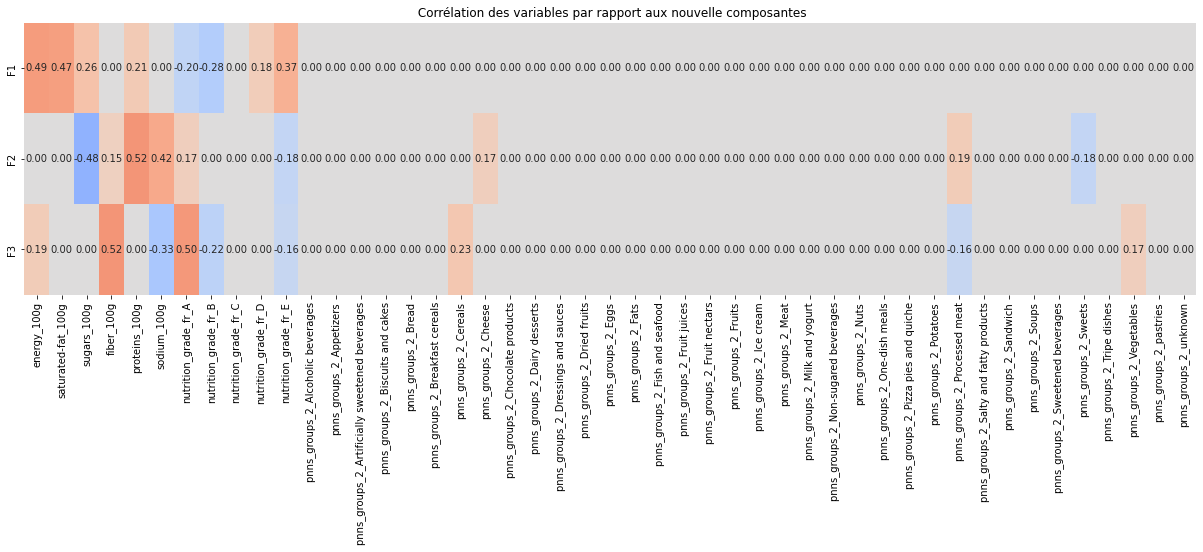

In [68]:


plt.figure(figsize=(21,5))
sns.heatmap(pcs, vmin=-1, vmax=1, cmap="coolwarm", fmt="0.2f",annot=True,cbar= False)

plt.title(" Corrélation des variables par rapport aux nouvelle composantes")
plt.show()


In [69]:
def correlation_graph (pca,
                       x_y,
                      features):



    x,y=x_y
    # Taille de l'image (en inches)
    plt.figure(figsize =(12,12))

    # Pour chaque composante :
    for i in range(0, pcs.values.shape[1]):

        # Les flèches
        plt.arrow(0,0,
                pcs.values[x, i],
                pcs.values[y, i],
                head_width=0.02,
                head_length=0.03 )

        # Les labels
        plt.annotate(dataP3_PCA.columns[i],(pcs.values[x, i] ,
                pcs.values[y, i]),textcoords="offset points", xytext=(10,10))

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # Titre
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

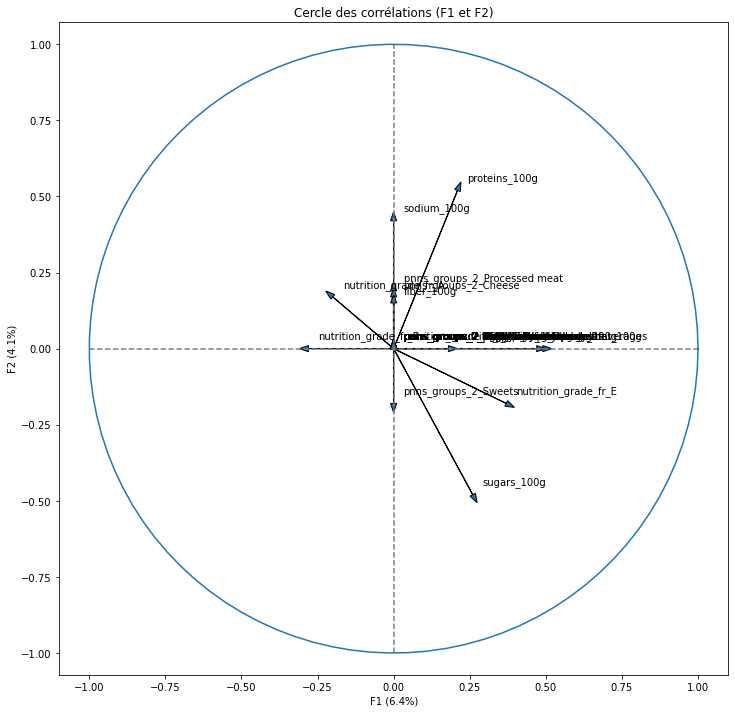

In [70]:
# Cercle correlation sur F1,F2
x_y = (0,1)

correlation_graph(pca, x_y,pcs.columns)

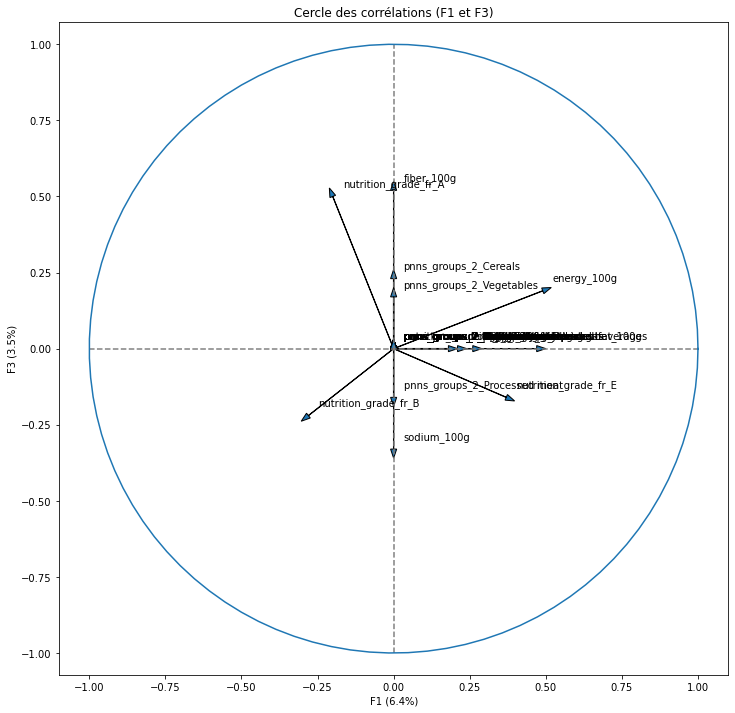

In [71]:
# Cercle correlation sur F1,F3
x_y = (0,2)

correlation_graph(pca, x_y, dataP3_PCA.columns)

## ANNEXE

Réalisation d'une ANOVA "one-ways"

In [72]:
groupes= ['A','B','C','D','E']
result_groupes =[]
rows = []
df_ANOVA = pd.DataFrame()

for var in list_norm_test:

    for gpe in groupes:

        result_gpe = pd.Series(dataP3_clean.loc[dataP3_clean['nutrition_grade_fr']== gpe ,var],name="Groupe{0}".format(gpe))
        result_groupes.append(result_gpe)

    result_var = pd.Series(f_oneway(*result_groupes) , name= var )
    df_ANOVA[var] = result_var
df_ANOVA.rename(index= {0:"f" , 1: "p_value"})

,energy_100g,saturated-fat_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g,fruits-vegetables-nuts_100g
f,38365.29422,125738.755787,149469.048468,161747.453159,168610.304332,173449.909292,176853.735424
p_value,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


L'hypothèse H0 est là aussi vérifiée.